# Przetwarzanie i przechowywanie opisu siatki trójkątnej na płaszczyźnie

### Konfiguracja

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.colors as mcolors
from matplotlib.widgets import Button
import json as js

TOLERANCE = 0.15

def dist(point1, point2):
    return np.sqrt(np.power(point1[0] - point2[0], 2) + np.power(point1[1] - point2[1], 2))

class _Button_callback(object):
    def __init__(self, scenes):
        self.i = 0
        self.scenes = scenes
        self.adding_points = False
        self.added_points = []
        self.adding_lines = False
        self.added_lines = []
        self.adding_rects = False
        self.added_rects = []

    def set_axes(self, ax):
        self.ax = ax
        
    def next(self, event):
        self.i = (self.i + 1) % len(self.scenes)
        self.draw(autoscaling = True)

    def prev(self, event):
        self.i = (self.i - 1) % len(self.scenes)
        self.draw(autoscaling = True)
        
    def add_point(self, event):
        self.adding_points = not self.adding_points
        self.new_line_point = None
        if self.adding_points:
            self.adding_lines = False
            self.adding_rects = False
            self.added_points.append(PointsCollection([]))
         
    def add_line(self, event):   
        self.adding_lines = not self.adding_lines
        self.new_line_point = None
        if self.adding_lines:
            self.adding_points = False
            self.adding_rects = False
            self.added_lines.append(LinesCollection([]))

    def add_rect(self, event):
        self.adding_rects = not self.adding_rects
        self.new_line_point = None
        if self.adding_rects:
            self.adding_points = False
            self.adding_lines = False
            self.new_rect()
    
    def new_rect(self):
        self.added_rects.append(LinesCollection([]))
        self.rect_points = []
    
    def on_click(self, event):
        if event.inaxes != self.ax:
            return
        new_point = (event.xdata, event.ydata)
        if self.adding_points:
            self.added_points[-1].add_points([new_point])
            self.draw(autoscaling = False)
        elif self.adding_lines:
            if self.new_line_point is not None:
                self.added_lines[-1].add([self.new_line_point, new_point])
                self.new_line_point = None
                self.draw(autoscaling = False)
            else:
                self.new_line_point = new_point
        elif self.adding_rects:
            if len(self.rect_points) == 0:
                self.rect_points.append(new_point)
            elif len(self.rect_points) == 1:
                self.added_rects[-1].add([self.rect_points[-1], new_point])
                self.rect_points.append(new_point)
                self.draw(autoscaling = False)
            elif len(self.rect_points) > 1:
                if dist(self.rect_points[0], new_point) < (np.mean([self.ax.get_xlim(), self.ax.get_ylim()])*TOLERANCE):
                    self.added_rects[-1].add([self.rect_points[-1], self.rect_points[0]])
                    self.new_rect()
                else:    
                    self.added_rects[-1].add([self.rect_points[-1], new_point])
                    self.rect_points.append(new_point)
                self.draw(autoscaling = False)
        
    def draw(self, autoscaling = True):
        if not autoscaling:
            xlim = self.ax.get_xlim()
            ylim = self.ax.get_ylim()
        self.ax.clear()
        for collection in (self.scenes[self.i].points + self.added_points):
            if len(collection.points) > 0:
                self.ax.scatter(*zip(*(np.array(collection.points))), **collection.kwargs)
        for collection in (self.scenes[self.i].lines + self.added_lines + self.added_rects):
            self.ax.add_collection(collection.get_collection())
        self.ax.autoscale(autoscaling)
        if not autoscaling:
            self.ax.set_xlim(xlim)
            self.ax.set_ylim(ylim)
        plt.draw()


### Interfejsy

[Dostępne kolory](https://matplotlib.org/3.1.1/gallery/color/named_colors.html)

[Dostępne znaczniki punktów](https://matplotlib.org/3.1.1/api/markers_api.html#module-matplotlib.markers)

In [2]:
class Scene:
    def __init__(self, points=[], lines=[]):
        self.points=points
        self.lines=lines

class PointsCollection:
    def __init__(self, points, **kwargs):
        self.points = points
        self.kwargs = kwargs
    
    def add_points(self, points):
        self.points = self.points + points

class LinesCollection:
    def __init__(self, lines, **kwargs):
        self.lines = lines
        self.kwargs = kwargs
        
    def add(self, line):
        self.lines.append(line)
        
    def get_collection(self):
        return mcoll.LineCollection(self.lines, **self.kwargs)
    
class Plot:
    def __init__(self, scenes = [Scene()], json = None):
        if json is None:
            self.scenes = scenes
        else:
            self.scenes = [Scene([PointsCollection(pointsCol) for pointsCol in scene["points"]], 
                                 [LinesCollection(linesCol) for linesCol in scene["lines"]]) 
                           for scene in js.loads(json)]
        
    def __configure_buttons(self):
        plt.subplots_adjust(bottom=0.2)
        ax_prev = plt.axes([0.6, 0.05, 0.15, 0.075])
        ax_next = plt.axes([0.76, 0.05, 0.15, 0.075])
        ax_add_point = plt.axes([0.44, 0.05, 0.15, 0.075])
        ax_add_line = plt.axes([0.28, 0.05, 0.15, 0.075])
        ax_add_rect = plt.axes([0.12, 0.05, 0.15, 0.075])
        b_next = Button(ax_next, 'Następny')
        b_next.on_clicked(self.callback.next)
        b_prev = Button(ax_prev, 'Poprzedni')
        b_prev.on_clicked(self.callback.prev)
        b_add_point = Button(ax_add_point, 'Dodaj punkt')
        b_add_point.on_clicked(self.callback.add_point)
        b_add_line = Button(ax_add_line, 'Dodaj linię')
        b_add_line.on_clicked(self.callback.add_line)
        b_add_rect = Button(ax_add_rect, 'Dodaj figurę')
        b_add_rect.on_clicked(self.callback.add_rect)
        return [b_prev, b_next, b_add_point, b_add_line, b_add_rect]
    
    def add_scene(self, scene):
        self.scenes.append(scene)
    
    def add_scenes(self, scenes):
        self.scenes = self.scenes + scenes

    def toJson(self):
        return js.dumps([{"points": [np.array(pointCol.points).tolist() for pointCol in scene.points], 
                          "lines":[linesCol.lines for linesCol in scene.lines]} 
                         for scene in self.scenes])    
     
    def get_added_points(self):
        if self.callback:
            return self.callback.added_points
        else:
            return None
  
    def get_added_lines(self):
        if self.callback:
            return self.callback.added_lines
        else:
            return None
        
    def get_added_figure(self):
        if self.callback:
            return self.callback.added_rects
        else:
            return None
    
    def get_added_elements(self):
        if self.callback:
            return Scene(self.callback.added_points, self.callback.added_lines+self.callback.added_rects)
        else:
            return None
    
    def draw(self):
        plt.close()
        fig = plt.figure()
        self.callback = _Button_callback(self.scenes)
        self.widgets = self.__configure_buttons()
        ax = plt.axes(autoscale_on = False)
        self.callback.set_axes(ax)
        fig.canvas.mpl_connect('button_press_event', self.callback.on_click)
        plt.show()
        self.callback.draw()
        

In [3]:
class Point:
    def __init__(self, x , y):
        self.x = x
        self.y = y
    
    def toTuple(self):
        return self.x, self.y
    def __str__(self):
        return f"{[self.x,self.y]}"
    def __repr__(self):
        return f"{[self.x,self.y]}"
    def __eq__(self, other):
        if isinstance(other, Point):
            return self.x == other.x and self.y==other.y
        return False


In [4]:
class Line:
    def __init__(self, a , b):
        self.a = a
        self.b = b
    
    def toTuple(self):
        return self.a, self.b
    def __str__(self):
        return f"{[self.a,self.b]}"
    def __repr__(self):
        return f"{[self.a,self.b]}"


In [5]:
class Triangle:
    def __init__(self,a,b,c):
        self.a=a
        self.b=b
        self.c=c
    def toTuple(self):
        return self.a, self.b,self.c
    
    def __str__(self):
        return f"{[self.a,self.b,self.c]}"
    def __eq__(self, other):
        if isinstance(other, Triangle):
            return self.a == other.a and self.b==other.b and self.c==other.c
        return False
#    def toLines(self):
#        lines=[]
#        lines.append(Line(self.a,self.b))
#        lines.append(Line(self.b,self.c))
#        lines.append(Line(self.c,self.a))
#        return(lines)
        

In [6]:
import json as js
def importPoints(filename):
    loadedPoints=[]
    loadedTriangles=[]
    
    with open(filename, 'r') as file:
        json = file.read()
    for points in js.loads(json)["points"]:
        for point in points:
            loadedPoints.append(Point(point[0],point[1]))
    for triangles in js.loads(json)["triangles"]:
        for triangle in triangles:
            loadedTriangles.append(Triangle(triangle[0],triangle[1],triangle[2]))
    
    return loadedPoints, loadedTriangles

In [7]:
def exportPoints(filename,points,triangles):
    
    toWrite=js.dumps({"points": [[point.toTuple() for point in points]],
                      "triangles": [[triangle.toTuple() for triangle in triangles]]})
    with open(filename, 'w') as file:
        json = file.write(toWrite)
    
    return True

In [8]:
import random

def generatePoints(x1,y1,x2,y2,n):
    points=[]
    for x in range(n):
         points.append(Point(random.uniform(x1,x2),random.uniform(y1,y2)))
    return points


In [9]:
def trianglesToLines(triangles,points):
    lines=[]
    for t in triangles:
        a=points[t.a].toTuple()
        b=points[t.b].toTuple()
        c=points[t.c].toTuple()
        lines.append((a,b))
        lines.append((b,c))
        lines.append((c,a))
        
    return lines
    

<IPython.core.display.Javascript object>


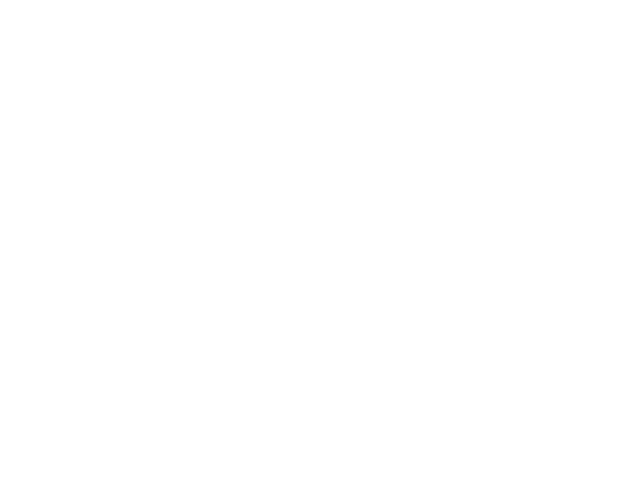

In [10]:
%matplotlib notebook
points=generatePoints(0,0,1,1,10)
triangles=[]
triangles.append(Triangle(1,2,3))
triangles.append(Triangle(4,5,6))
triangles.append(Triangle(7,8,9))
lines=trianglesToLines(triangles,points)

#print(lines)
scenes=[Scene([PointsCollection([point.toTuple() for point in points])],
              lines=[LinesCollection( lines)])]

plot=Plot(scenes)
plot.draw() 

In [11]:
exportPoints("punkty.txt",points,triangles)

True

In [12]:
points,triangles=importPoints("siatka.txt")
for p in points:
    print (p)
for t in triangles:
    print (t)

[1, 4]
[2, 2]
[2, 7]
[2, 10]
[4, 5]
[5, 9]
[6, 3]
[7, 7]
[8, 5]
[9, 2]
[0, 1, 4]
[0, 2, 4]
[2, 3, 5]
[2, 4, 5]
[4, 5, 7]
[1, 4, 6]
[4, 6, 7]
[6, 7, 8]
[6, 8, 9]


<IPython.core.display.Javascript object>


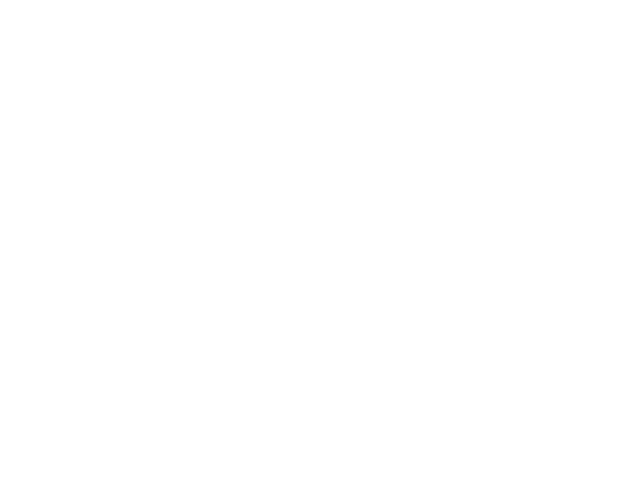

In [13]:
points,triangles=importPoints("siatka.txt")
scenes=[Scene([PointsCollection([point.toTuple() for point in points])],
              lines=[LinesCollection(trianglesToLines(triangles,points))])]

plot=Plot(scenes)
plot.draw() 

# Winged edge data structure

In [14]:
class VertexW:
    def __init__(self,x,y,edge=None): 
        self.x=x
        self.y=y
        self.edge=edge
    def __eq__(self, other):
        if isinstance(other, VertexW):
            return self.x == other.x and self.y==other.y
        return False
    def __repr__(self):
        return f"{[self.x,self.y]}"
    def toTuple(self):
        return self.x, self.y
class FaceW: 
    def __init__(self,edge):
        self.edge=edge
    def __repr__(self):
        return f"{[self.edge]}"
    def __eq__(self, other):
        if isinstance(other, FaceW):
            return self.edge == other.edge
        return False
class EdgeW: 
    def __init__(self,vOrg,vDest,fl=None,fr=None,elcw=None,elcww=None,ercw=None,ercww=None):
        self.vertexOrigin=vOrg
        self.vertexDestination=vDest
        self.faceLeft=fl
        self.faceRight=fr
        self.edgeLeftCw=elcw
        self.edgeLeftCww=elcww
        self.edgeRightCw=ercw
        self.edgeRightCww=ercww
    def __repr__(self):
        return f"{[self.vertexOrigin,self.vertexDestination]}"
    def __eq__(self, other):
        if isinstance(other, EdgeW):
            return (self.vertexOrigin == other.vertexOrigin and self.vertexDestination==other.vertexDestination or 
                    self.vertexOrigin == other.vertexDestination and self.vertexDestination==other.vertexOrigin)
        return False
    def neighbourEdges(self):
        edges=[]
        edges.append(self.edgeLeftCw)
        edges.append(self.edgeLeftCww)
        edges.append(self.edgeRightCw)
        edges.append(self.edgeRightCww)
        return edges
    def toTuple(self):
        return self.vertexOrigin.toTuple(), self.vertexDestination.toTuple()
#,self.faceLeft,self.faceRight,self.edgeLeftCw,self.edgeLeftCww,self.edgeRightCw,self.edgeRightCww]}"
    


In [15]:

a=VertexW(1,2)
b=VertexW(2,1)
e=EdgeW(a,b)
e.toTuple()


((1, 2), (2, 1))

In [16]:
def findCommonEdge(t1,t2):
    commonPoints=[]
    for p1 in t1.toTuple():
        for p2 in t2.toTuple():
            if(p1==p2):
                commonPoints.append(p1)
    if(len(commonPoints)==2):
        return True,commonPoints[0],commonPoints[1]
    else:
        return False,None,None

In [17]:
def findEdgesAdjacentToEdge(t1,t2,sp,ep):
    for p in t1:
        if(p!=sp and p!=ep):
            lp=p
    for p in t2:
        if(p!=sp and p!=ep):
            rp=p
    return lp,rp

In [18]:
def findEdgeinEdges(edge,edges):
    for e in edges:
        if e==edge:
            return e

In [19]:
def det1(a,b,c):
    if (isinstance(a,VertexW)):
        a=a.toTuple()
    if (isinstance(b,VertexW)):
        b=b.toTuple()
    if (isinstance(c,VertexW)):
        c=c.toTuple()
    
    return a[0]*b[1] + a[1]*c[0] + b[0]*c[1] - b[1]*c[0] - a[1]*b[0] - a[0]*c[1]

In [20]:
def findOtherFace(t1,t2,face,faces,vertexes,edges):
    myedges=[]
    a=vertexes[t1.a]
    b=vertexes[t1.b]
    c=vertexes[t1.c]
    d=vertexes[t2.a]
    e=vertexes[t2.b]
    f=vertexes[t2.c]
    myedges.append(findEdgeinEdges(EdgeW(a,b),edges))
    myedges.append(findEdgeinEdges(EdgeW(a,c),edges))
    myedges.append(findEdgeinEdges(EdgeW(b,c),edges))
    myedges.append(findEdgeinEdges(EdgeW(d,e),edges))
    myedges.append(findEdgeinEdges(EdgeW(d,f),edges))
    myedges.append(findEdgeinEdges(EdgeW(e,f),edges))
    for edge in myedges:
        if(edge.faceLeft!=face):
            return edge.faceLeft
    
    

In [21]:
def findOtherFace(t1,t2,orginalEdge,startP,endP,faces,vertexes,edges,ifLeft):
    myedges=[]
    a=vertexes[t1.a]
    b=vertexes[t1.b]
    c=vertexes[t1.c]
    d=vertexes[t2.a]
    e=vertexes[t2.b]
    f=vertexes[t2.c]
    myedges.append(findEdgeinEdges(EdgeW(a,b),edges))
    myedges.append(findEdgeinEdges(EdgeW(a,c),edges))
    myedges.append(findEdgeinEdges(EdgeW(b,c),edges))
    myedges.append(findEdgeinEdges(EdgeW(d,e),edges))
    myedges.append(findEdgeinEdges(EdgeW(d,f),edges))
    myedges.append(findEdgeinEdges(EdgeW(e,f),edges))
    result=None
    for edge in myedges:
        if edge != orginalEdge:
            if(orginalEdge.vertexOrigin==edge.vertexOrigin):
                if(det1(orginalEdge.vertexOrigin,orginalEdge.vertexDestination,edge.vertexDestination)>0):#krawędź leży na lewo
                    orginalEdge.edgeLeftCww=edge
                    edge.edgeRightCww=orginalEdge
                    if(ifLeft):
                        if(edge.faceRight!=None):
                            result=edge.faceRight
                else:
                    orginalEdge.edgeRightCww=edge
                    edge.edgeLeftCww=orginalEdge
                    if(not(ifLeft)):
                        if(edge.faceLeft!=None):
                            result=edge.faceLeft
            if(orginalEdge.vertexOrigin==edge.vertexDestination):
                if(det1(orginalEdge.vertexOrigin,orginalEdge.vertexDestination,edge.vertexOrigin)>0):#krawędź leży na lewo i kończy się w początku
                    orginalEdge.edgeLeftCww=edge
                    edge.edgeLeftCw=orginalEdge
                    if(ifLeft):
                        if(edge.faceLeft!=None):
                            result=edge.faceLeft
                else:
                    orginalEdge.edgeRightCww=edge
                    edge.edgeRightCw=orginalEdge
                    
                    if(not(ifLeft)):
                        if(edge.faceRight!=None):
                            result=edge.faceRight
            if(orginalEdge.vertexDestination==edge.vertexOrigin):
                if(det1(orginalEdge.vertexOrigin,orginalEdge.vertexDestination,edge.vertexDestination)>0):#krawędź leży na lewo i kończy się w początku
                    orginalEdge.edgeLeftCw=edge
                    edge.edgeLeftCww=orginalEdge
                    
                    if(ifLeft):
                        if(edge.faceLeft!=None):
                            result=edge.faceLeft
                else:
                    orginalEdge.edgeRightCw=edge
                    edge.edgeRightCww=orginalEdge
                    
                    if(not(ifLeft)):
                        if(edge.faceRight!=None):
                            result=edge.faceRight
            if(orginalEdge.vertexDestination==edge.vertexDestination):
                if(det1(orginalEdge.vertexOrigin,orginalEdge.vertexDestination,edge.vertexOrigin)>0):#krawędź leży na lewo i kończy się w początku
                    orginalEdge.edgeLeftCw=edge
                    edge.edgeRightCw=orginalEdge
                    
                    if(ifLeft):
                        if(edge.faceRight!=None):
                            result=edge.faceRight
                else:
                    orginalEdge.RightCw=edge
                    edge.LeftCw=orginalEdge
                    if(not(ifLeft)):
                        if(edge.faceLeft!=None):
                            result=edge.faceLeft
    return result
    

In [22]:
def returnSecondEdgeFromSameSide(orginalEdge,mainEdge):
    if(mainEdge.edgeLeftCw==orginalEdge):
        return mainEdge.edgeLeftCww
    elif(mainEdge.edgeLeftCww==orginalEdge):
        return mainEdge.edgeLeftCw
    elif(mainEdge.edgeRightCw==orginalEdge):
        return mainEdge.edgeRightCww
    elif(mainEdge.edgeRightCww==orginalEdge):
        return mainEdge.edgeRightCw
    

In [23]:
def fromTrianglesToWingedEdge(points,triangles):
    edges=[]
    vertexes=[]
    faces=[]
    for point in points: #tworzenie wierzchołków
        vertexes.append(VertexW(point.x,point.y,None))
    for triangle in triangles: #tworzenie krawędzi
        pointA=vertexes[triangle.a]
        pointB=vertexes[triangle.b]
        pointC=vertexes[triangle.c]
        edge1=EdgeW(pointA,pointB)
        edge2=EdgeW(pointA,pointC)
        edge3=EdgeW(pointB,pointC)
        
        
        if(edge1 not in edges):
            edges.append(edge1)
            
        if(edge2 not in edges):
            edges.append(edge2)
            
        if(edge3 not in edges):            
            edges.append(edge3)
            
        faces.append(FaceW(edges[-1]))
        
        if(det1(pointA.toTuple(),pointB.toTuple(),pointC.toTuple())>0): #to na lewo
            edge1.faceLeft=faces[-1]
        else:
            edge1.faceRight=faces[-1]
        if(det1(pointA.toTuple(),pointC.toTuple(),pointB.toTuple())>0): #to na lewo
            edge2.faceLeft=faces[-1]
        else:
            edge2.faceRight=faces[-1]
        if(det1(pointB.toTuple(),pointC.toTuple(),pointA.toTuple())>0): #to na lewo
            edge3.faceLeft=faces[-1]
        else:
            edge3.faceRight=faces[-1]
        
        
    #dla każdej krawędzi znajdujemy trójkąty do których należy
    for edge in edges:
        for vertex in vertexes:
            if (vertex==edge.vertexOrigin):
                vertex.edge=edge
            elif (vertex==edge.vertexDestination):
                vertex.edge=edge
    
    for t1 in triangles:
        for t2 in triangles:#dodawanie do krawędzi następników i porzedników i ścian
            result=findCommonEdge(t1,t2)
            if(result[0]):
                edge=findEdgeinEdges(EdgeW(vertexes[result[1]],vertexes[result[2]]),edges)
                if(edge.faceLeft==None):
                    face=findOtherFace(t1,t2,edge,vertexes[result[1]],vertexes[result[2]],faces,vertexes,edges,True)#uzupełniamy o drugą ścianę
                    edge.faceLeft=face
                if(edge.faceRight==None):
                    face=findOtherFace(t1,t2,edge,vertexes[result[1]],vertexes[result[2]],faces,vertexes,edges,False)#uzupełniamy o drugą ścianę
                    edge.faceRight=face
                
    for edge in edges: #uzupełnienie o brakujących poprzedników i następników
        if (edge.edgeLeftCww==None):
            if(edge.edgeLeftCw!=None):
                edge.edgeLeftCww=returnSecondEdgeFromSameSide(edge,edge.edgeLeftCw)
        if(edge.edgeLeftCw==None):
            if (edge.edgeLeftCww!=None):
                edge.edgeLeftCw=returnSecondEdgeFromSameSide(edge,edge.edgeLeftCww)
        if(edge.edgeRightCww is None):
            if (edge.edgeRightCw!=None):
                edge.edgeRightCww=returnSecondEdgeFromSameSide(edge,edge.edgeRightCw)        
        if(edge.edgeRightCw is None):
            if (edge.edgeRightCww!=None):
                edge.edgeRightCw=returnSecondEdgeFromSameSide(edge,edge.edgeRightCww)
                
    
    return edges, faces, vertexes
            


In [24]:
#edges,faces,vertexes=fromTrianglesToWingedEdge (points,triangles)
#for edge in edges:
#    print("Krawędź: " + str(edge))
#    print("Prawe sąsiady: " + str(edge.edgeRightCw)+" , "+ str(edge.edgeRightCww))
#    print("Lewe sąsiady: " + str(edge.edgeLeftCw)+" , "+ str(edge.edgeLeftCww))
#    print("Prawa ściana: " + str(edge.faceRight))
#   print("Lewa ściana: " + str(edge.faceLeft))

In [25]:
def returnOtherEnd(edge,vertex):
    if(edge.vertexOrigin==vertex):
        return edge.vertexDestination
    elif(edge.vertexDestination==vertex):
        return edge.vertexOrigin

In [26]:
def findNeighbourVertexes(edges,vertex,result=[]):
    for edge in edges:
        if(edge.vertexOrigin==vertex):
            result.append(edge.vertexDestination)
        if(edge.vertexDestination==vertex):
            result.append(edge.vertexOrigin)
    return result

In [27]:
def findAdjacentEdges1(vertex,edges):
    adjacentEdges=[]
    for edge in edges:
        if(edge.vertexOrigin==vertex):
            adjacentEdges.append(edge)
        if(edge.vertexDestination==vertex):
            adjacentEdges.append(edge)
    return adjacentEdges

# MOVING THROUGH MESH

In [28]:
def findAdjacent2(vertex,edges,scenes=None,redPoints=None,visualization=False,ifVertex=True):
    firstEdge=vertex.edge
    edge=vertex.edge
    adjacentEdges=[]
    if (scenes==None and visualization):
        scenes=[]
    if (redPoints==None and visualization):
        redPoints=[]
    
    greenlines=[]
    
    if (visualization):
        scenes.append(Scene([PointsCollection([vertex.toTuple() for vertex in vertexes]),PointsCollection([vertex.toTuple()],color='black')],
              lines=[LinesCollection([edge.toTuple() for edge in edges]),LinesCollection(greenlines.copy(),color='green')]))
    while(True):
        if (visualization):
            greenlines.append(edge.toTuple())
            scenes.append(Scene([PointsCollection([vertex.toTuple() for vertex in vertexes]),PointsCollection([vertex.toTuple()],color='black')],
                  lines=[LinesCollection([edge.toTuple() for edge in edges]),LinesCollection(greenlines.copy(),color='green')]))
        if(edge.vertexDestination==vertex):
            if(edge.edgeRightCw==None):
                scenes.clear
                adjacentEdges=findAdjacent3(edge,vertex,edges,scenes)
                break
            else:
                edge=edge.edgeRightCw
        else:
            if(edge.edgeLeftCww==None):
                scenes.clear
                adjacentEdges=findAdjacent3(edge,vertex,edges,scenes)
                break
            else:
                edge=edge.edgeLeftCww
        adjacentEdges.append(edge)
        if(edge == firstEdge):
            break
    if (ifVertex):
        adjacentVertexes=[]                
        for edge in adjacentEdges:
            if(edge.vertexOrigin==vertex):
                vertexToAdd=edge.vertexDestination
            elif(edge.vertexDestination==vertex):
                vertexToAdd=edge.vertexOrigin
            if(vertexToAdd):
                adjacentVertexes.append(vertexToAdd)
                if(visualization):
                    redPoints.append(vertexToAdd.toTuple())
                    scenes.append(Scene([PointsCollection([vertex.toTuple() for vertex in vertexes]),PointsCollection(redPoints.copy(),color='red'),PointsCollection([vertex.toTuple()],color='black')],
                                            lines=[LinesCollection([edge.toTuple() for edge in edges])]))
        
        if (visualization):
            return adjacentVertexes,scenes
        else:
            return adjacentVertexes,None
    if (visualization):
        return adjacentEdges,scenes
    else:
        return adjacentEdges,None

In [29]:
def findAdjacent3(firstEdge,vertex,edges,scenes=None):
    if(scenes==None):
        visualization=False
    else:
        visualization=True
    edge=firstEdge
    adjacentEdges=[]
    redpoints=[]
    redlines=[]
    adjacentEdges.append(edge)
    if (visualization):
        scenes.append(Scene([PointsCollection([vertex.toTuple() for vertex in vertexes]),PointsCollection([vertex.toTuple()],color='black'),PointsCollection(redpoints.copy(),color='red')],
                            lines=[LinesCollection([edge.toTuple() for edge in edges]),LinesCollection(redlines.copy(),color='red')]))
    while(True):
        if (visualization):
            redlines.append(edge.toTuple())
            scenes.append(Scene([PointsCollection([vertex.toTuple() for vertex in vertexes]),PointsCollection([vertex.toTuple()],color='black'),PointsCollection(redpoints.copy(),color='red')],
                  lines=[LinesCollection([edge.toTuple() for edge in edges]),LinesCollection(redlines.copy(),color='red')]))
        if(edge.vertexDestination==vertex):
            if(edge.edgeLeftCw==None):
                return adjacentEdges
            else:
                edge=edge.edgeLeftCw
        else:
            if(edge.edgeRightCww==None):
                return adjacentEdges
            else:
                edge=edge.edgeRightCww
        adjacentEdges.append(edge)
        if (edge == firstEdge):
            break
    return (adjacentEdges,scenes)

In [43]:
def findSecondAdjacent(vertex,edges,visualization):
    startVertex=vertex
    firstEdge=vertex.edge
    edge=vertex.edge
    adjacentVertexes=[]
    scenes=[]
    greenlines=[]
    redpoints=[]
    final=[]
    
    if (visualization):
        scenes.append(Scene([PointsCollection([vertex.toTuple() for vertex in vertexes]),PointsCollection([vertex.toTuple()],color='black')],
              lines=[LinesCollection([edge.toTuple() for edge in edges]),LinesCollection(greenlines.copy(),color='green')]))
    adjacentVertexes=findAdjacent2(vertex,edges,scenes,redpoints,True,True)[0]
    final=adjacentVertexes.copy()
    for av in adjacentVertexes:
        secondAdjacentVertexes=findAdjacent2(av,edges,scenes,redpoints,True,True)[0]
        for sav in secondAdjacentVertexes:
            if (sav not in final):
                final.append(sav)
    if (visualization):
        scenes.append(Scene([PointsCollection([vertex.toTuple() for vertex in vertexes]),PointsCollection([startVertex.toTuple()],color='black')],
              lines=[LinesCollection([edge.toTuple() for edge in edges])]))
    
    return final,scenes
                

# MESH GENERATION

<IPython.core.display.Javascript object>


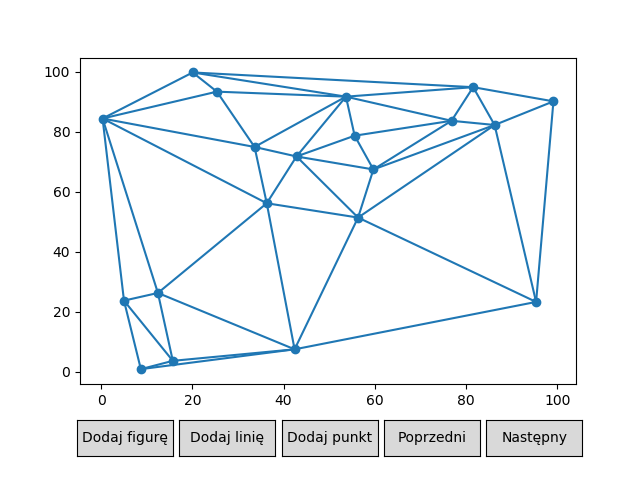

In [46]:
from scipy.spatial import Delaunay

points=generatePoints(0,0,100,100,20)
naturalPoints=[]

for p in points:
    naturalPoints.append(p.toTuple())
    
tri = Delaunay(naturalPoints)
triangles=[]
for t in tri.simplices:
    triangles.append(Triangle(t[0],t[1],t[2]))

#exportPoints("duza_siatka.txt",vertexes,triangles)

edges,faces,vertexes=fromTrianglesToWingedEdge (points,triangles)

scenes=[Scene([PointsCollection(naturalPoints)],
              lines=[LinesCollection([edge.toTuple() for edge in edges])])]


plot=Plot(scenes)
plot.draw() 



<IPython.core.display.Javascript object>


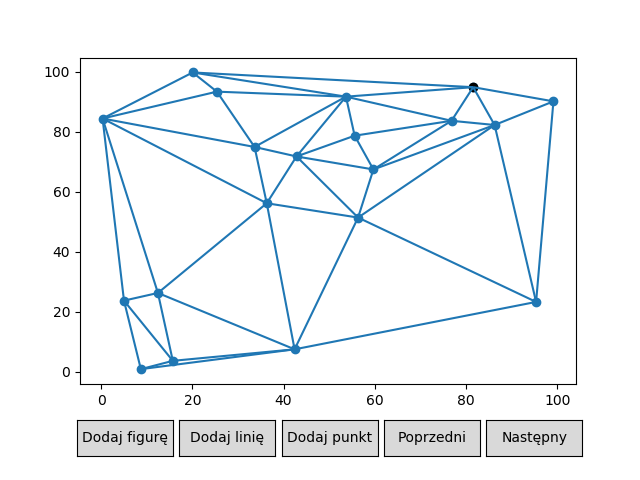

In [47]:
#edges,faces,vertexes=fromTrianglesToWingedEdge (points,triangles)

result=findAdjacent2(vertexes[4],edges,[],[],True)

#scenes=[Scene([PointsCollection([point.toTuple() for point in points])],
#              lines=[LinesCollection(trianglesToLines(triangles,points))])]

plot=Plot(result[1])
plot.draw()
#result

<IPython.core.display.Javascript object>


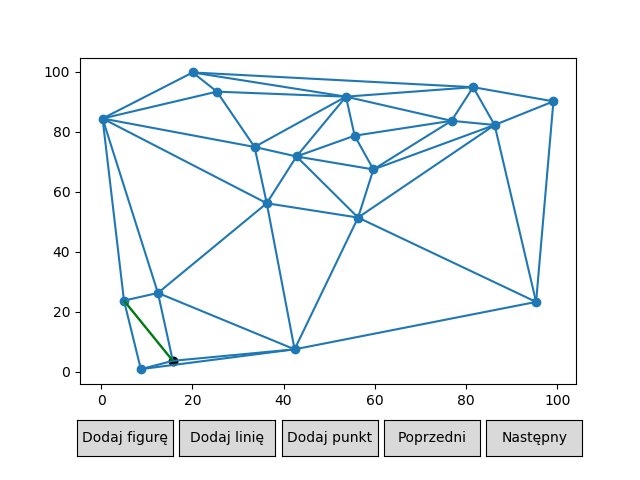

[[8.71796053791537, 0.8483326960899595],
 [15.7265625031755, 3.6158039051872426],
 [12.458510297245251, 26.245941046733535],
 [36.319642947368116, 56.152740325332815],
 [56.33860836220158, 51.38050671880784],
 [95.36355178604423, 23.256475574376868],
 [5.020476080192493, 23.68894376748314],
 [42.42242848347308, 7.451844904636329],
 [0.3268996292654758, 84.40721987809337],
 [33.64678542266832, 74.92056388563878],
 [42.84248071912182, 71.75352257256186],
 [86.26905519081727, 82.24507407911904],
 [59.69920035738146, 67.42466784258781],
 [99.16403347405057, 90.12550416848177]]

In [49]:
#edges,faces,vertexes=fromTrianglesToWingedEdge (points,triangles)

result=findSecondAdjacent(vertexes[5],edges,True)

#scenes=[Scene([PointsCollection([point.toTuple() for point in points])],
#              lines=[LinesCollection(trianglesToLines(triangles,points))])]

plot=Plot(result[1])
plot.draw()
result[0]

In [34]:
def findSecondAdjacentVertexes(vertex,edges):
    firstEdge=vertex.edge
    edge=vertex.edge
    adjacentVertexes=findAdjacentVertexes2(vertex,edges)
    adjacentedges=[]
    secondAdjacentVertexes=[]
    
    for av in adjacentVertexes:
        adjacentEdges=findAdjacentEdges2(av,edges)
        for edge in adjacentEdges:
            if(edge.vertexDestination in adjacentVertexes and edge.vertexOrigin in adjacentVertexes):
                adjacentEdges.remove(edge)
        for edge in adjacentEdges:
            if(edge.vertexDestination in adjacentVertexes):
                if(edge.vertexOrigin not in secondAdjacentVertexes ):
                    secondAdjacentVertexes.append(edge.vertexOrigin)
            if(edge.vertexOrigin in adjacentVertexes):
                if(edge.vertexDestination not in secondAdjacentVertexes ):
                    secondAdjacentVertexes.append(edge.vertexDestination)
    secondAdjacentVertexes.remove(vertex)
    return secondAdjacentVertexes

In [35]:
def findAdjacentFaces(vertex,edges):
    firstEdge=vertex.edge
    print(firstEdge)
    edge=firstEdge
    adjacentFaces=[]
    if(edge.vertexDestination==vertex):
        adjacentFaces.append(edge.faceRight)
        #if(edge.edgeRightCw==None):
        #    return findAdjacentVertexes3(edge,vertex,edges)
        #else:
        edge=edge.edgeRightCw
    else:
        adjacentFaces.append(edge.faceLeft)
        #if(edge.edgeLeftCww==None):
        #    return findAdjacentVertexes3(edge,vertex,edges)
        #else:
        edge=edge.edgeLeftCww
    
    while(edge != firstEdge):
        if(edge.vertexDestination==vertex):
            adjacentFaces.append(edge.faceRight)
            #if(edge.edgeRightCw==None):
            #    return findAdjacentVertexes3(edge,vertex,edges)
            #else:
            edge=edge.edgeRightCw
        else:
            adjacentFaces.append(edge.faceLeft)
            #if(edge.edgeLeftCww==None):
            #    return findAdjacentVertexes3(edge,vertex,edges)
            #else:
            edge=edge.edgeLeftCww
    return adjacentFaces

In [36]:
points,triangles=importPoints("siatka.txt")

edges,faces,vertexes=fromTrianglesToWingedEdge (points,triangles)
#print(findNeighbourVertexes(edges,VertexW(4,5)))

#result=findAdjacentEdges2(vertexes[0],edges)
#print(result)

print(findAdjacentVertexes2(vertexes[4],edges))

#print(findSecondAdjacentVertexes(vertexes[4],edges))
#print(findAdjacentFaces(vertexes[4],edges))


#for vertex in vertexes:
#    print(vertex.edge)


NameError: name 'findAdjacentVertexes2' is not defined

In [ ]:
points,triangles=importPoints("siatka.txt")
scenes=[Scene([PointsCollection([point.toTuple() for point in points])],
              lines=[LinesCollection(trianglesToLines(triangles,points))])]

plot=Plot(scenes)
plot.draw() 

In [ ]:
for face in faces:
    print (face)
for edge in edges:
    print("Krawędź: " + str(edge))
    print("Prawe sąsiady: " + str(edge.edgeRightCw)+" , "+ str(edge.edgeRightCww))
    print("Lewe sąsiady: " + str(edge.edgeLeftCw)+" , "+ str(edge.edgeLeftCww))
    print("Prawa ściana: " + str(edge.faceRight))
    print("Lewa ściana: " + str(edge.faceLeft))
    


In [ ]:
points,triangles=importPoints("siatka.txt")
scenes=[Scene([PointsCollection([point.toTuple() for point in points])],
              lines=[LinesCollection(trianglesToLines(triangles,points))])]

plot=Plot(scenes)
plot.draw() 

In [ ]:
class Line:
    def __init__(self, a , b):
        self.a = a
        self.b = b
    
    def toTuple(self):
        return self.a, self.b
    def __str__(self):
        return f"{[self.a,self.b]}"
    def __repr__(self):
        return f"{[self.a,self.b]}"

In [ ]:
#Dodaj tu punkty, figury i/lub odcinki!
plot1 = Plot()
plot1.draw()

In [ ]:
plot2 = Plot([plot1.get_added_elements()])
plot2.draw()